>  ## Project 2 ##



Εισάγουμε χρήσιμες βιβλιοθήκες.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import numpy as np

from transformers import pipeline

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from collections import Counter

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

from scipy.stats import pearsonr

import pickle
import warnings

In [3]:
warnings.filterwarnings("ignore")

### Ερώτημα 1: Study over time  ###

**Αρχικά θα απαντήσουμε για το έτος 2019**

Κρατάμε τις στήλες comments και listing_id από τα αρχέια ```reviews.csv``` για κάθε μήνα για το έτος 2019, καθώς και τις στήλες id και neighbourhood από τα αρχεία ```listings.csv```, τα οποία και θα αντιστοιχίσουμε μεταξύ τους (comments με neighbourhoods) για την διεξαγωγή του τελευταίου ερωτήματος του πρώτου μέρους της εργασίας.

In [4]:
# Keep only the columns we need from reviews.csv
comments = ['listing_id','comments']

# Keep only the columns we need from listings.csv
neighborhoods = ['id','neighbourhood']

In [5]:
#APRIL

# Read comments from reviews.csv
df1_comments = pd.read_csv('data/2019/april/reviews.csv',usecols=comments)

# Shuffle the DataFrame to keep random occuranses when we drop duplicates (not only the first one)
df1_comments = df1_comments.sample(frac=1).reset_index(drop=True)
df1_comments = df1_comments.drop_duplicates(subset=['listing_id'])                    # Remove duplicate ids from comments.csv

# Read id and neighborhood from listings.csv
df1_neighborhoods = pd.read_csv('data/2019/april/listings.csv',usecols=neighborhoods)

# Merge the column "neighborhood" (from listings.csv) to April DataFrame based on the same id and listing_id
april_df = pd.concat([df1_comments.set_index('listing_id'), df1_neighborhoods.set_index('id')['neighbourhood']], axis=1, join='outer')
april_df = april_df.reset_index()
april_df = april_df.rename(columns={'index': 'id'})

In [6]:
#FEBRUARY

# Read comments from reviews.csv
df2_comments = pd.read_csv('data/2019/febrouary/reviews.csv',usecols=comments)

# Shuffle the DataFrame to keep random occuranses when we drop duplicates (not only the first one)
df2_comments = df2_comments.sample(frac=1).reset_index(drop=True)
df2_comments = df2_comments.drop_duplicates(subset=['listing_id'])                    # Remove duplicate ids from comments.csv

# Read id and neighborhood from listings.csv
df2_neighborhoods = pd.read_csv('data/2019/febrouary/listings.csv',usecols=neighborhoods)

# Merge the column "neighborhood" (from listings.csv) to February DataFrame based on the same id and listing_id
february_df = pd.concat([df2_comments.set_index('listing_id'), df2_neighborhoods.set_index('id')['neighbourhood']], axis=1, join='outer')
february_df = february_df.reset_index()
february_df = february_df.rename(columns={'index': 'id'})

In [7]:
#MARCH

# Read comments from reviews.csv
df3_comments = pd.read_csv('data/2019/march/reviews.csv',usecols=comments)

# Shuffle the DataFrame to keep random occuranses when we drop duplicates (not only the first one)
df3_comments = df3_comments.sample(frac=1).reset_index(drop=True)
df3_comments = df3_comments.drop_duplicates(subset=['listing_id'])                    # Remove duplicate ids from comments.csv

# Read id and neighborhood from listings.csv
df3_neighborhoods = pd.read_csv('data/2019/march/listings.csv',usecols=neighborhoods)

# Merge the column "neighborhood" (from listings.csv) to March DataFrame based on the same id and listing_id
march_df = pd.concat([df3_comments.set_index('listing_id'), df3_neighborhoods.set_index('id')['neighbourhood']], axis=1, join='outer')
march_df = march_df.reset_index()
march_df = march_df.rename(columns={'index': 'id'})

In [8]:
# Merge april_df, february_df, march_df
df_19 = pd.concat([april_df, february_df, march_df], ignore_index=True)

Αφαιρούμε τα διπλότυπα IDs (duplicates) και τις NaN τιμές.

In [9]:
# Drop duplicate values 
df_19 = df_19.drop_duplicates().reset_index(drop=True)

# Drop NaN values 
df_19 = df_19.dropna()

df_19

,id,comments,neighbourhood
0,21237746,Super nice appartment in a very special part o...,Exarcheia
1,18035251,Very good location. The house is very clean. T...,Plaka
2,13972503,The host canceled this reservation 14 days bef...,Plaka
3,26257124,"Appartement très propre, moderne, à la haute...",Pedion Areos
4,4021939,Lovely and artistic place:) Thank you for offe...,Pangrati
...,...,...,...
21774,24391872,We really enjoyed staying at Marios apartment....,Neos Kosmos
21775,32438113,Ενα μοντέρνο καλαίσθητο με όλα τα απαραίτητα ο...,Pangrati
21776,31425429,Best location in Athens and brand new apartmen...,Neos Kosmos
21777,29787012,"Great apartment, very well equipped, and very ...",Patisia


Κατεβάζουμε τα stop words με τη χρήση της nltk.

In [10]:
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/christina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Αφαιρούμε τα σχόλια (comments) που δεν είναι γραμμένα στα Αγγλικά ####

Ορίζουμε μια συνάρτηση is_english που ελέγχει για Αγγλικά μέσα σε ένα comment.

In [11]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        # If it fails, consider it as non-English
        return False

Κρατάμε μόνο τα Αγγλικά comments.

In [12]:
# Find if a comment is in english or not 
df_19['is_english'] = df_19['comments'].apply(is_english)

# Keep only English comments 
df_19 = df_19[df_19['is_english']]

# Drop the is_english helper column
df_19 = df_19.drop(columns=['is_english'])

df_19

,id,comments,neighbourhood
0,21237746,Super nice appartment in a very special part o...,Exarcheia
1,18035251,Very good location. The house is very clean. T...,Plaka
2,13972503,The host canceled this reservation 14 days bef...,Plaka
4,4021939,Lovely and artistic place:) Thank you for offe...,Pangrati
6,22802228,"Great place, pretty close from Akropolis, if ...",Neos Kosmos
...,...,...,...
21773,32276334,"The place is fantastic, with a stunning view o...",Plaka
21774,24391872,We really enjoyed staying at Marios apartment....,Neos Kosmos
21776,31425429,Best location in Athens and brand new apartmen...,Neos Kosmos
21777,29787012,"Great apartment, very well equipped, and very ...",Patisia


Δημιουργούμε μια συνάρτηση clean_text η οποία καθαρίζει τα δεδομένα σύμφωνα με την εκφώνηση.

In [13]:
def clean_text(comment):

    # Remove punctuation
    comment = re.sub(r'[^\w\s]', '', comment)

    # Rerplace br with ' '
    comment = comment.replace('br','')

    # Convert to lowercase
    comment = comment.lower()

    # Remove any emojis
    comment = comment.encode('ascii', 'ignore').decode('ascii')

    # Remove any hashtags or links
    comment = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', comment, flags=re.MULTILINE)

    # Remove stopwords
    word_tokens = word_tokenize(comment)
    Newcomment = [word for word in word_tokens if word not in stop_words]

    return ' '.join(Newcomment)

Καλούμε τη συνάρτηση clean_text για το df_2019.

In [14]:
# Convert comments to str
df_19 = df_19.astype(str)

# Apply clean_text for every comment
df_19['comments'] = df_19['comments'].apply(clean_text)

df_19

,id,comments,neighbourhood
0,21237746,super nice appartment special part city really...,Exarcheia
1,18035251,good location house clean door cleaned serious...,Plaka
2,13972503,host canceled reservation 14 days arrival auto...,Plaka
4,4021939,lovely artistic place thank offering us memora...,Pangrati
6,22802228,great place pretty close akropolis enjoy walki...,Neos Kosmos
...,...,...,...
21773,32276334,place fantastic stunning view acropolis litera...,Plaka
21774,24391872,really enjoyed staying marios apartment came r...,Neos Kosmos
21776,31425429,best location athens new apartment near everyt...,Neos Kosmos
21777,29787012,great apartment well equipped nice host,Patisia


#### Hugging Face for Sentiment ####  
Θα χρησιμοποιήσουμε το μοντέλο roberta-base-sentiment

In [15]:
# Initialize pipeline
sentiment_pip = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment', tokenizer='cardiffnlp/twitter-roberta-base-sentiment', max_length=512, truncation=True)

Δημιουργούμε μια συνάρτηση η οποία επιστρέφει το sentiment για μία πρόταση.

In [16]:
def get_sentiment(comment):
    
    res = sentiment_pip(comment)[0]

    # Create a label map
    label_map = {
        'LABEL_0': 'negative',
        'LABEL_1': 'neutral',
        'LABEL_2': 'positive'
    }
    
    return label_map[res['label']]

Καλούμε τη get_sentiment για το df μας.  
(Κρατάμε 2000 τυχαία σχόλια από το αρχικό μας DataFrame)

In [17]:
# Create a sample df from 2000 random values of our df 
df_sample19 = df_19.sample(n=2000)

Βρίσκουμε το συναίσθημα για το  dataset που κρατήσαμε.

In [18]:
# Find sentiment for the sample df 
df_sample19['sentiment'] = df_sample19['comments'].apply(get_sentiment)

df_sample19

,id,comments,neighbourhood,sentiment
19260,18942981,beautiful little place main thing nice clean g...,Koukaki,positive
14195,25666881,seriously amazing host place find better accom...,Kolonos,positive
2171,23809228,place amazing honestly perfect location perfec...,Neos Kosmos,positive
17822,21638201,wonderful stay corinnas place apartment ight s...,Psyri,positive
6184,27305004,convenient spacious appartment 6 people relati...,Neos Kosmos,positive
...,...,...,...,...
17709,25862956,perfect place stay night athens location feels...,Kerameikos,positive
13067,24514669,great value lots space hot water nice balcony ...,Larissis,positive
175,15066525,vagelis great host welcomed us many thoughtful...,Koukaki,positive
16426,15991857,comfy cozy close metro bus lines great host qu...,Pangrati,positive


**Κάνουμε την ίδια ανάλυση για το έτος 2023.**

Κρατάμε τις στήλες comments και listing_id από τα αρχέια ```reviews.csv``` για κάθε μήνα για το έτος 2023, καθώς και τις στήλες id και neighbourhood από τα αρχεία ```listings.csv```, τα οποία και θα αντιστοιχίσουμε μεταξύ τους (comments με neighbourhoods) για την διεξαγωγή του τελευταίου ερωτήματος του πρώτου μέρους της εργασίας.

In [19]:
# Keep only the columns we need from reviews.csv
comments = ['listing_id','comments']

# Keep only the columns we need from listings.csv
neighborhoods = ['id','neighbourhood_cleansed']

In [20]:
#JUNE

# Read comments from reviews.csv
df1_comments = pd.read_csv('data/2023/june/reviews.csv',usecols=comments)

# Shuffle the DataFrame to keep random occuranses when we drop duplicates (not only the first one)
df1_comments = df1_comments.sample(frac=1).reset_index(drop=True)
df1_comments = df1_comments.drop_duplicates(subset=['listing_id'])                    # Remove duplicate ids from comments.csv

# Read id and neighborhood from listings.csv
df1_neighborhoods = pd.read_csv('data/2023/june/listings.csv',usecols=neighborhoods)

# Merge the column "neighborhood" (from listings.csv) to June DataFrame based on the same id and listing_id
june_df = pd.concat([df1_comments.set_index('listing_id'), df1_neighborhoods.set_index('id')['neighbourhood_cleansed']], axis=1, join='outer')
june_df = june_df.reset_index()
june_df = june_df.rename(columns={'index': 'id'})

In [21]:
#MARCH

# Read comments from reviews.csv
df2_comments = pd.read_csv('data/2023/march/reviews.csv',usecols=comments)

# Shuffle the DataFrame to keep random occuranses when we drop duplicates (not only the first one)
df2_comments = df2_comments.sample(frac=1).reset_index(drop=True)
df2_comments = df2_comments.drop_duplicates(subset=['listing_id'])                    # Remove duplicate ids from comments.csv

# Read id and neighborhood from listings.csv
df2_neighborhoods = pd.read_csv('data/2023/march/listings.csv',usecols=neighborhoods)

# Merge the column "neighborhood" (from listings.csv) to March DataFrame based on the same id and listing_id
march_df = pd.concat([df2_comments.set_index('listing_id'), df2_neighborhoods.set_index('id')['neighbourhood_cleansed']], axis=1, join='outer')
march_df = march_df.reset_index()
march_df = march_df.rename(columns={'index': 'id'})

In [22]:
#SEPTEMBER

# Read comments from reviews.csv
df3_comments = pd.read_csv('data/2023/september/reviews.csv',usecols=comments)

# Shuffle the DataFrame to keep random occuranses when we drop duplicates (not only the first one)
df3_comments = df3_comments.sample(frac=1).reset_index(drop=True)
df3_comments = df3_comments.drop_duplicates(subset=['listing_id'])                    # Remove duplicate ids from comments.csv

# Read id and neighborhood from listings.csv
df3_neighborhoods = pd.read_csv('data/2023/september/listings.csv',usecols=neighborhoods)

# Merge the column "neighborhood" (from listings.csv) to September DataFrame based on the same id and listing_id
september_df = pd.concat([df3_comments.set_index('listing_id'), df3_neighborhoods.set_index('id')['neighbourhood_cleansed']], axis=1, join='outer')
september_df = september_df.reset_index()
september_df = september_df.rename(columns={'index': 'id'})

In [23]:
# Merge april_df, february_df, march_df
df_23 = pd.concat([june_df, march_df, september_df], ignore_index=True)

Αφαιρούμε τα διπλότυπα IDs και τις NaN τιμές.

In [24]:
# Drop duplicate values 
df_23 = df_23.drop_duplicates().reset_index(drop=True)

# Drop NaN values 
df_23 = df_23.dropna(subset=['comments'])
df_23 = df_23.dropna(subset=['neighbourhood_cleansed'])

df_23

,id,comments,neighbourhood_cleansed
0,34066463,"Το σπίτι είναι πολύ κοντά στο μετρό, απίστευτα...",ΚΕΡΑΜΕΙΚΟΣ
1,32404256,"Amazing apartment in a great location, next to...",ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ
2,23266320,Basilhs is very friendly and available,ΚΟΛΩΝΟΣ
3,41054995,Très bonne adresse. Conviviale et emplacement ...,ΚΕΡΑΜΕΙΚΟΣ
4,5428088,"awesome space, totally recommended",ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ
...,...,...,...
29436,807124581683501987,A great location close to tall the popular des...,ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
29439,891900968739055405,Nice place walking distance to everything.<br/...,ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
29445,822306664980717859,Best AirBnB I’ve ever stayed at!!<br/>Exactly ...,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ
29446,40753850,The apartment was very clean and quite. Excell...,ΝΕΑ ΚΥΨΕΛΗ


Κρατάμε μόνο τα Αγγλικά comments.

In [25]:
# Find if a comment is in english or not 
df_23['is_english'] = df_23['comments'].apply(is_english)

# Keep only English comments 
df_23 = df_23[df_23['is_english']]

# Drop the is_english helper column
df_23 = df_23.drop(columns=['is_english'])

Καλούμε την συνάρτηση clean_text για το έτος 2023 ώστε να καθαρίσουμε τα δεδομένα σύμφωνα με την εκφώνηση.

In [26]:
# Convert comments to str
df_23 = df_23.astype(str)

# Apply clean_text for every comment
df_23['comments'] = df_23['comments'].apply(clean_text)

df_23

,id,comments,neighbourhood_cleansed
1,32404256,amazing apartment great location next metro st...,ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ
2,23266320,basilhs friendly available,ΚΟΛΩΝΟΣ
4,5428088,awesome space totally recommended,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ
6,39709715,great place close acropolis,ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
7,44449129,nice place close main places athens,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ
...,...,...,...
29436,807124581683501987,great location close tall popular destination ...,ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
29439,891900968739055405,nice place walking distance everythinghost res...,ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
29445,822306664980717859,best airbnb ive ever stayed atexactly per phot...,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ
29446,40753850,apartment clean quite excellent location trans...,ΝΕΑ ΚΥΨΕΛΗ


#### Hugging Face for Sentiment ####  

Καλούμε τη get_sentiment για το df μας.  
(Κρατάμε 2000 τυχαία σχόλια από το αρχικό μας DataFrame)

In [27]:
# Create a sample df from 2000 random values of our df 
df_sample23 = df_23.sample(n=2000)

Βρίσκουμε το συναίσθημα για το dataset που κρατήσαμε.

In [28]:
# Find sentiment for the sample df 
df_sample23['sentiment'] = df_sample23['comments'].apply(get_sentiment)

df_sample23

,id,comments,neighbourhood_cleansed,sentiment
22299,27563227,wonderful apartmentexcellent safe neighborhood...,ΠΑΓΚΡΑΤΙ,positive
25308,41096347,great place location quiet neighborhood close ...,ΘΗΣΕΙΟ,positive
26267,21934137,nice cozy clean apartment highly recommend,ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ,positive
7575,42573453,everything really nice recommend without secon...,ΓΟΥΔΙ,positive
5559,591761795453170327,best location could ever ask located really cl...,ΚΟΛΩΝΑΚΙ,positive
...,...,...,...,...
15237,49556452,lovely stay janes place well located clean qui...,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,positive
6104,54076421,great time staying apartment described nice re...,ΠΕΤΡΑΛΩΝΑ,positive
7627,825284072131367208,fabulous stay nothing complain airbnb host rec...,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,positive
413,20325613,check okay free wifi enough wall plugs 2 cross...,ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ,negative


**Σύγκριση συναισθημάτων για κάθε έτος. Θα δημιουργήσουμε ένα ιστόγραμμα για κάθε έτος.**

Ιστόγραμμα για το 2019.

(array([0, 1, 2]),
 [Text(0, 0, 'positive'), Text(1, 0, 'neutral'), Text(2, 0, 'negative')])

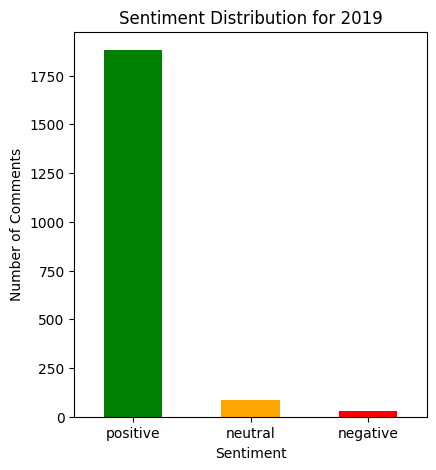

In [29]:
sent_count19 = df_sample19['sentiment'].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sent_count19.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution for 2019')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')

plt.xticks(rotation=0)

Ιστόγραμμα για το 2023.

(array([0, 1, 2]),
 [Text(0, 0, 'positive'), Text(1, 0, 'neutral'), Text(2, 0, 'negative')])

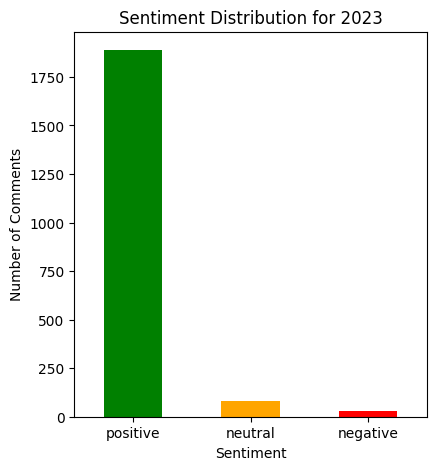

In [30]:
sent_count23 = df_sample23['sentiment'].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sent_count23.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution for 2023')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')

plt.xticks(rotation=0)

**Σύγκριση συναισθήματος ανά γειτονιά με την πάροδο του χρόνου.**  

Θα φτιάξουμε δύο ιστογράμματα, ένα για κάθε χρονιά.

Ιστόγραμμα για τις γειτονίες του έτους 2019

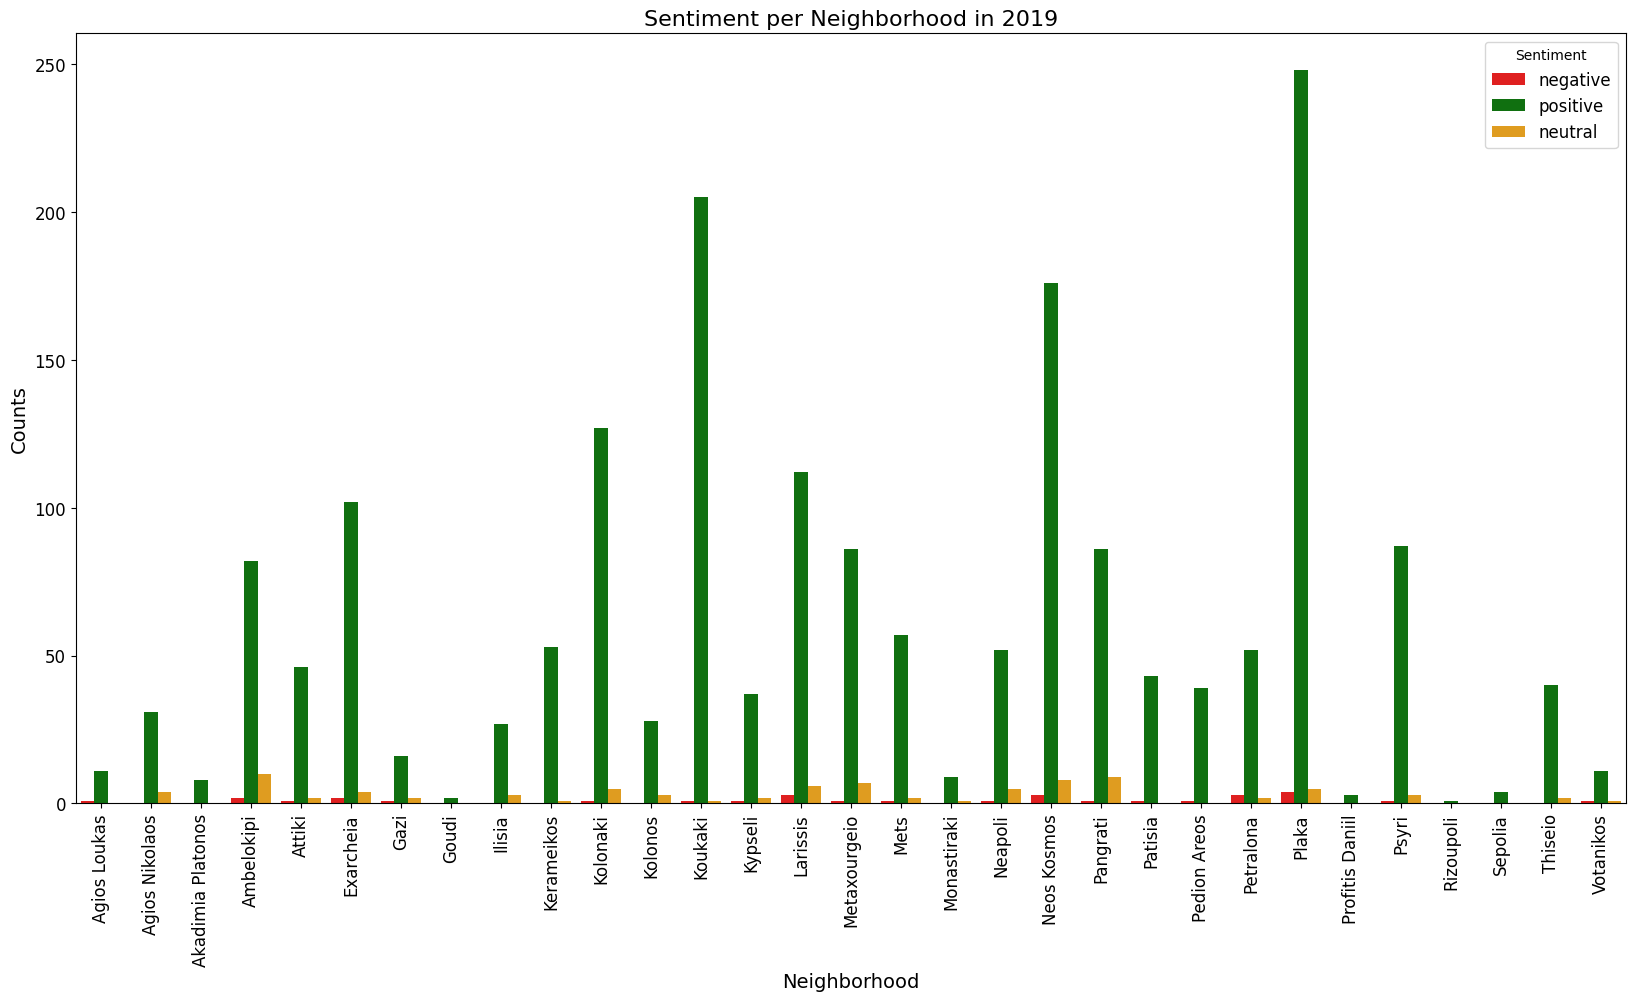

In [31]:
# Group by neighborhood and sentiment, and count the occurrences
sentiment_counts = df_sample19.groupby(['neighbourhood', 'sentiment']).size().reset_index(name='counts')

# Set up the plot
plt.figure(figsize=(20, 10))

# Use seaborn to create a bar plot
sns.barplot(data=sentiment_counts, x='neighbourhood', y='counts', hue='sentiment', palette={'positive': 'green', 'neutral': 'orange', 'negative': 'red'})

# Customizing the plot
plt.title('Sentiment per Neighborhood in 2019', fontsize=16)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

Ιστόγραμμα για τις γειτονιές του έτους 2023.

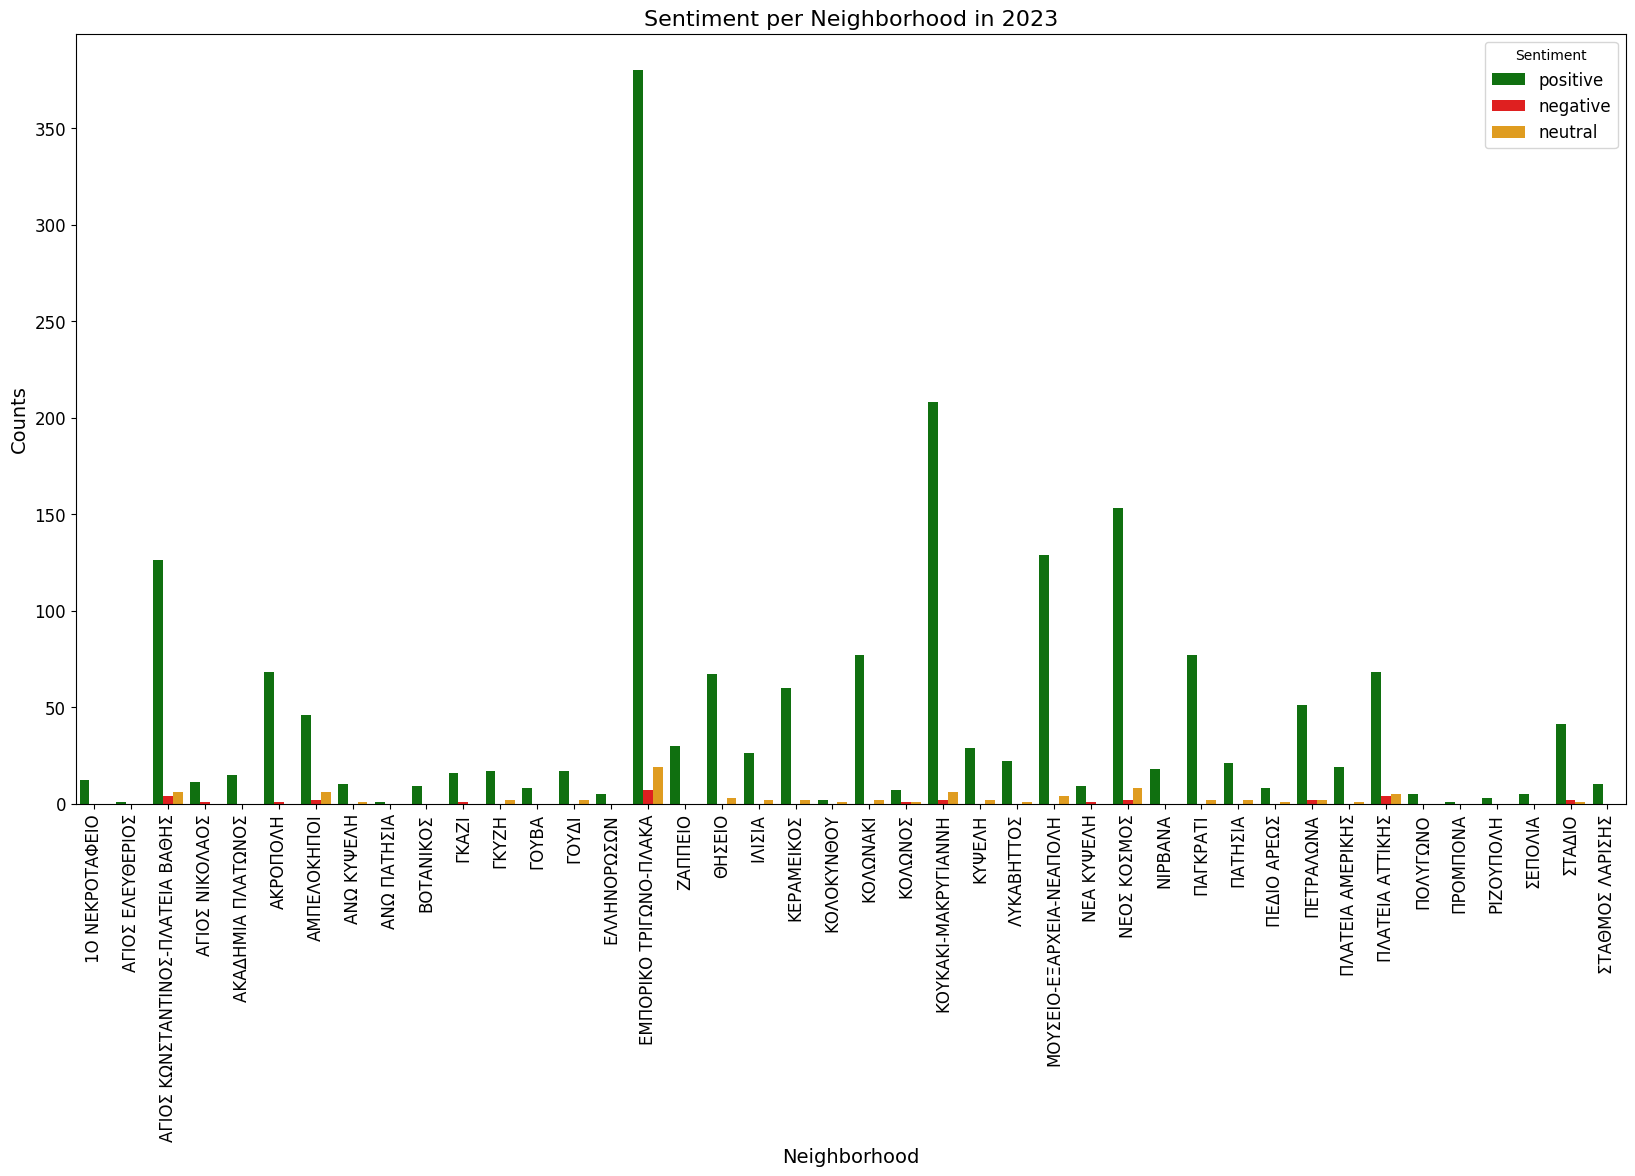

In [32]:
# Group by neighborhood and sentiment, and count the occurrences
sentiment_counts = df_sample23.groupby(['neighbourhood_cleansed', 'sentiment']).size().reset_index(name='counts')

# Set up the plot
plt.figure(figsize=(20, 10))

# Use seaborn to create a bar plot
sns.barplot(data=sentiment_counts, x='neighbourhood_cleansed', y='counts', hue='sentiment', palette={'positive': 'green', 'neutral': 'orange', 'negative': 'red'})

# Customizing the plot
plt.title('Sentiment per Neighborhood in 2023', fontsize=16)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

### Ερώτημα 2: Sentiment analysis ###

Θα δημιουργήσουμε δύο νέα dataset από τα δεδομένα που προέκυψαν στο προηγούμενο ερώτημα. **(Θα χρησιμοποιήσουμε τα δεδομένα του έτους 2023)**
 
Ένα αρχείο ```train.tsv``` (θα είναι το 80% των συνολικών data points) το οποίο θα χρησιμοποιηθεί για εκπαίδευση των μοντέλων μας.  
Ένα αρχειο ```test.tsv``` (το 20% των data points) το οποίο θα χρησιμοποιηθεί για να δοκιμάσουμε το μοντέλο μας και να κάνουμε μία πρόβλεψη.

Για τον διαχωρισμό των data θα χρησιμοποιήσουμε την train_test_split η οποία θα διαχωρίσει το αρχικό μας dataframe στα δύο μέρη που θέλουμε και βάζοντας διαφορετικά δεδομένα στο κάθε αρχείο που θα φτιάξουμε.

In [33]:
# Split the DataFrame (df_sample23) into 80% training and 20% testing
train_df, test_df = train_test_split(df_sample23, test_size=0.2, random_state=42)

Αποθηκεύουμε τα dataframes που δημιουργήσαμε παραπάνω σε αρχεία .tsv

In [34]:
# Save the training set to train.tsv
train_df.to_csv('train.tsv', sep='\t', index=False)

# Save the testing set to test.tsv
test_df.to_csv('test.tsv', sep='\t', index=False)

Διαβάζουμε τα αρχεία που φτιάξαμε, τα οποία στη συνέχεια θα επεξεργαστούμε

In [35]:
# Read files
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

# Fill empty rows from 'comments' column with "NULL"
train.fillna("NULL", inplace=True)
test.fillna("NULL", inplace=True)

**TF-IDF**

Υπολογίζουμε τους πίνακες Tf-idf (για τα comments του train set και του test set) και αποθηκεύουμε τα χαρακτηριστικά τους σε αρχεία *.pkl (ένα για το train και ένα για το test αντίστοιχα)

In [36]:
# Compute Tf-idf
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train['comments'].astype(str))
test_tfidf = vectorizer.transform(test['comments'].astype(str))

print(train_tfidf)

  (0, 2979)	0.4978668994562977
  (0, 1922)	0.15119219071937987
  (0, 2560)	0.1647247073641918
  (0, 3245)	0.22788907153098614
  (0, 361)	0.15253363682785825
  (0, 593)	0.272339427611427
  (0, 580)	0.3424206164685285
  (0, 2276)	0.5863555925734557
  (0, 461)	0.19286287456303308
  (0, 4144)	0.1647247073641918
  (0, 3311)	0.16544323023421265
  (1, 3581)	0.18896739281253758
  (1, 2027)	0.22301638906917828
  (1, 2378)	0.301457483181683
  (1, 2338)	0.4921424307340488
  (1, 466)	0.5742290508552633
  (1, 787)	0.2782831840763403
  (1, 3519)	0.2646603978333447
  (1, 884)	0.16441346171118115
  (1, 2960)	0.1839704251351114
  (1, 361)	0.14149797291522984
  (1, 4144)	0.1528070310641845
  (2, 1571)	0.14806154996620377
  (2, 4351)	0.31834711204677624
  (2, 3827)	0.28039141516533295
  :	:
  (1599, 405)	0.217981842718372
  (1599, 4834)	0.10004663556649608
  (1599, 3773)	0.1347665973600843
  (1599, 1672)	0.14195822278442743
  (1599, 792)	0.14969865128550527
  (1599, 2928)	0.15523496842647422
  (1599, 294

In [37]:
print(test_tfidf)

  (0, 4901)	0.389140040697177
  (0, 4732)	0.12331072346106714
  (0, 4396)	0.15917600990943784
  (0, 4229)	0.20387452495690622
  (0, 4100)	0.2763195399257069
  (0, 3733)	0.19537526301192643
  (0, 3191)	0.22224105157525167
  (0, 2878)	0.20155406879489338
  (0, 2797)	0.13750858036321775
  (0, 2672)	0.151710421374351
  (0, 2538)	0.21189756018507253
  (0, 2100)	0.08475792883834021
  (0, 1778)	0.13495235554341856
  (0, 1615)	0.16058617462828959
  (0, 1503)	0.19937433528405296
  (0, 965)	0.19537526301192643
  (0, 788)	0.14600784230819755
  (0, 732)	0.1677213970582762
  (0, 667)	0.17445251157378178
  (0, 568)	0.1490057939942725
  (0, 530)	0.1363907310063435
  (0, 461)	0.08609137924116346
  (0, 442)	0.20155406879489338
  (0, 405)	0.11967585387907462
  (0, 368)	0.19937433528405296
  :	:
  (396, 353)	0.16129436829717222
  (396, 128)	0.14990202415920523
  (397, 4392)	0.47803659060808357
  (397, 3311)	0.27906184149205554
  (397, 3245)	0.7687850855827968
  (397, 2100)	0.32027331897664263
  (398, 478

In [38]:
# Save Tf-idf using pickle
with open('train_tfidf.pkl', 'wb') as f:
    pickle.dump(train_tfidf, f)
    
with open('test_tfidf.pkl', 'wb') as f:
    pickle.dump(test_tfidf, f)

**Word Embeddings**

Υπολογίζουμε τα Word Embeddings (για τα comments του train set και του test set) και αποθηκεύουμε τα χαρακτηριστικά τους σε αρχεία *.pkl

In [39]:
# Compute Word Embeddings
sentences = [review.split() for review in train['comments'].astype(str)]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [40]:
# Function to compute average word embeddings for reviews
def get_word_embeddings(reviews, model, vector_size):

    # Initialize an empty list to store the embeddings for each review
    embeddings = []

    for review in reviews:

        # Split the review comment into single words
        words = review.split()

        # Filter out words that are not present in the Word2Vec model
        word_vecs = [model.wv[word] for word in words if word in model.wv]

        # If there are word vectors for any words in the review
        if word_vecs:

            # Compute the average word vector for the review by averaging the word vectors of all words
            avg_embedding = np.mean(word_vecs, axis=0)
            
            # Append the average word vector to the embeddings list
            embeddings.append(avg_embedding)
        else:

            # If there are no word vectors for any words in the review
            # Append a zero vector of length vector_size to the embeddings list
            embeddings.append(np.zeros(vector_size))

    # Convert the list of embeddings into a 2D numpy array (each row is a review and each column corresponds to a dimension of the word vectors)
    return np.array(embeddings)

In [41]:
train_embeddings = get_word_embeddings(train['comments'].astype(str), word2vec_model, 100)
test_embeddings = get_word_embeddings(test['comments'].astype(str), word2vec_model, 100)

In [42]:
# Save Word Embeddings using pickle
with open('train_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)
    
with open('test_embeddings.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)

#### **Training** ####

Αρχικά θα γίνει 10-fold Cross Validation για το κάθε μοντέλο (SVM, Random Forests, KNN) και ύστερα η εκπαίδευση των μοντέλων με τα train_tfidf και train_embeddings που δημιουργήσαμε παραπάνω.

Για αρχή, αποθηκεύουμε τα labels

In [43]:
# Load labels
train_labels = train['sentiment']
test_labels = test['sentiment']

Ορίζουμε τις μετρικές που θα χρησιμοπιήσουμε.

In [44]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

**SVM**  
Κάνουμε 10-fold Cross Validation και εκπαιδεύουμε το μοντέλο SVM

In [46]:
# Create SVC model
svc_model1 = SVC()

# Perform 10-fold cross-validation
cv_scores = cross_validate(svc_model1, train_tfidf, train_labels, cv=10, scoring=scoring, return_train_score=False)

# Save each specific score
mean_accuracy = cv_scores['test_accuracy'].mean()
mean_precision = cv_scores['test_precision'].mean()
mean_recall = cv_scores['test_recall'].mean()
mean_f1 = cv_scores['test_f1'].mean()

# Print the cross-validation scores
print('SVM model training (Tf-idf)')
print('___________________________\n')
print(f'Mean accuracy: {mean_accuracy}')
print(f'Mean precision: {mean_precision}')
print(f'Mean recall: {mean_recall}')
print(f'Mean F1 score: {mean_f1}')


# SVM model training
svc_model1.fit(train_tfidf, train_labels)

SVM model training (Tf-idf)
___________________________

Mean accuracy: 0.945
Mean precision: 0.8961781643081761
Mean recall: 0.945
Mean F1 score: 0.9192227401203195


SVC()

In [47]:
# Create SVC model
svc_model2 = SVC()

# Perform 10-fold cross-validation
cv_scores = cross_validate(svc_model2, train_embeddings, train_labels, cv=10, scoring=scoring, return_train_score=False)

mean_accuracy = cv_scores['test_accuracy'].mean()
mean_precision = cv_scores['test_precision'].mean()
mean_recall = cv_scores['test_recall'].mean()
mean_f1 = cv_scores['test_f1'].mean()

# Print the cross-validation scores
print('SVM model training (Word Embeddings)')
print('____________________________________\n')
print(f'Mean accuracy: {mean_accuracy}')
print(f'Mean precision: {mean_precision}')
print(f'Mean recall: {mean_recall}')
print(f'Mean F1 score: {mean_f1}')


# SVM model training
svc_model2.fit(train_embeddings, train_labels)

SVM model training (Word Embeddings)
____________________________________

Mean accuracy: 0.9425000000000001
Mean precision: 0.8883125
Mean recall: 0.9425000000000001
Mean F1 score: 0.9146027383051549


SVC()

**Random Forests**  
Κάνουμε 10-fold Cross Validation και εκπαιδεύουμε το μοντέλο Random Forests

In [48]:
# Create Random Forests model
rf_model1 = RandomForestClassifier()

# Perform 10-fold cross-validation
cv_scores = cross_validate(rf_model1, train_tfidf, train_labels, cv=10, scoring=scoring, return_train_score=False)

mean_accuracy = cv_scores['test_accuracy'].mean()
mean_precision = cv_scores['test_precision'].mean()
mean_recall = cv_scores['test_recall'].mean()
mean_f1 = cv_scores['test_f1'].mean()

# Print the cross-validation scores
print('Random Forest model training (Tf-idf)')
print('_____________________________________\n')
print(f'Mean accuracy: {mean_accuracy}')
print(f'Mean precision: {mean_precision}')
print(f'Mean recall: {mean_recall}')
print(f'Mean F1 score: {mean_f1}')

# Random Forests model training
rf_model1.fit(train_tfidf, train_labels)

Random Forest model training (Tf-idf)
_____________________________________

Mean accuracy: 0.944375
Mean precision: 0.8961447769261006
Mean recall: 0.944375
Mean F1 score: 0.9189094946063687


RandomForestClassifier()

In [49]:
# Create Random Forests model
rf_model2 = RandomForestClassifier()

# Perform 10-fold cross-validation
cv_scores = cross_validate(rf_model2, train_embeddings, train_labels, cv=10, scoring=scoring, return_train_score=False)

mean_accuracy = cv_scores['test_accuracy'].mean()
mean_precision = cv_scores['test_precision'].mean()
mean_recall = cv_scores['test_recall'].mean()
mean_f1 = cv_scores['test_f1'].mean()

# Print the cross-validation scores
print('Random Forests model training (Word Embeddings)')
print('_______________________________________________\n')
print(f'Mean accuracy: {mean_accuracy}')
print(f'Mean precision: {mean_precision}')
print(f'Mean recall: {mean_recall}')
print(f'Mean F1 score: {mean_f1}')

# Random Forests model training
rf_model2.fit(train_embeddings, train_labels)

Random Forests model training (Word Embeddings)
_______________________________________________

Mean accuracy: 0.9418749999999999
Mean precision: 0.9039171983851766
Mean recall: 0.9418749999999999
Mean F1 score: 0.919302646362962


RandomForestClassifier()

**KNN**  
Κάνουμε 10-fold Cross Validation και εκπαιδεύουμε το μοντέλο KNN

In [50]:
# Create KNN model
knn_model1 = KNeighborsClassifier(n_neighbors=5)

# Perform 10-fold cross-validation
cv_scores = cross_validate(knn_model1, train_tfidf, train_labels, cv=10, scoring=scoring, return_train_score=False)

mean_accuracy = cv_scores['test_accuracy'].mean()
mean_precision = cv_scores['test_precision'].mean()
mean_recall = cv_scores['test_recall'].mean()
mean_f1 = cv_scores['test_f1'].mean()

# Print the cross-validation scores
print('KNN model training (Tf-idf)')
print('___________________________\n')
print(f'Mean accuracy: {mean_accuracy}')
print(f'Mean precision: {mean_precision}')
print(f'Mean recall: {mean_recall}')
print(f'Mean F1 score: {mean_f1}')

# KNN model training
knn_model1.fit(train_tfidf, train_labels)

KNN model training (Tf-idf)
___________________________

Mean accuracy: 0.945
Mean precision: 0.8990927906192778
Mean recall: 0.945
Mean F1 score: 0.9206334741449425


KNeighborsClassifier()

In [51]:
# Create KNN model
knn_model2 = KNeighborsClassifier(n_neighbors=5)

# Perform 10-fold cross-validation
cv_scores = cross_validate(knn_model2, train_tfidf, train_labels, cv=10, scoring=scoring, return_train_score=False)

mean_accuracy = cv_scores['test_accuracy'].mean()
mean_precision = cv_scores['test_precision'].mean()
mean_recall = cv_scores['test_recall'].mean()
mean_f1 = cv_scores['test_f1'].mean()

# Print the cross-validation scores
print('KNN model training (Word Embeddings)')
print('____________________________________\n')
print(f'Mean accuracy: {mean_accuracy}')
print(f'Mean precision: {mean_precision}')
print(f'Mean recall: {mean_recall}')
print(f'Mean F1 score: {mean_f1}')

# KNN model training
knn_model2.fit(train_embeddings, train_labels)

KNN model training (Word Embeddings)
____________________________________

Mean accuracy: 0.945
Mean precision: 0.8990927906192778
Mean recall: 0.945
Mean F1 score: 0.9206334741449425


KNeighborsClassifier()

Σύμφωνα με τα δεδομένα που δόθηκαν και με τα παραπάνω αποτελέσματα παρατηρούμε πως το μοντέλο Random Forests δίνει πιο ακριβή αποτελέσματα (σχεδόν σε όλες τις μετρικές) και για τα δύο χαρακτηριστικά (Tf-Idf, Word Embeddings) από τα υπόλοιπα δύο μοντέλα. Συγκριτικά με τα άλλα δύο μοντέλα (SVM, KNN) παρατηρούμε πως το KNN δίνει πιο ακριβή αποτελέσματα από το SVM για το χαρακτηριστικό Word Embeddings, άρα το SVM είναι το λιγότερο ακριβές μοντέλο.  

Στην περίπτωση που επιλέξουμε μία μετρική ως σημειό αναφοράς, αυτή θα είναι η F1 score, διότι τα δεδομένα μας είναι ανισόρροπα με πολλές θετικές, λίγες ουδέτερες και πολύ λίγες αρνητικές κατηγορίες. Αυτό που κάνει η F1 Score είναι πως προσπαθεί να ισορροπήσει το accuracy και το recall, κάτι που είναι σημαντικό στην δική μας περίπτωση. Άρα και σύμφωνα με αυτή την μετρική το μοντέλο SVM αποτελεί το λιγότερο αποδωτικό, ενώ το μοντέλο Random Forrests το πιο αποδωτικό και για τα δύο χαρακτηριστικά.

**Testing**

Τεστάρουμε με το test set και τα 3 μοντέλα που εκπαιδεύσαμε παραπάνω. Αρχικά με το test set του Tf-idf και στη συνέχεια με το test set του Word Embeddings. Τα αποτελέσματα θα προκύψουν έχοντας επιλέξει την F1 score ως μετρική.

**SVM**

In [52]:
# Testing model using the test set (test_tfidf)
test_predictions = svc_model1.predict(test_tfidf)

# Calculate F1 Score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the scores
print('Testing SVM model (Tf-idf)')
print('__________________________\n')
print(f'Final Results: {f1}')

Testing SVM model (Tf-idf)
__________________________

Final Results: 0.3252032520325203


In [54]:
# Testing model using the test set (word embeddings)
test_predictions = svc_model2.predict(test_embeddings)

# Calculate F1 Score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the scores
print('Testing SVM model (Word Embeddings)')
print('___________________________________\n')
print(f'Final Results: {f1}')

Testing SVM model (Word Embeddings)
___________________________________

Final Results: 0.3247863247863248


**Random Forests**

In [55]:
# Testing model using the test set (test_tfidf)
test_predictions = rf_model1.predict(test_tfidf)

# Calculate F1 Score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the scores
print('Testing Random Forests model (Tf-idf)')
print('_____________________________________\n')
print(f'Final Results: {f1}')

Testing Random Forests model (Tf-idf)
_____________________________________

Final Results: 0.3252032520325203


In [56]:
# Testing model using the test set (word embeddings)
test_predictions = rf_model2.predict(test_embeddings)

# Calculate F1 Score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the scores
print('Testing Random Forests model (Word Embeddings)')
print('______________________________________________\n')
print(f'Final Results: {f1}')

Testing Random Forests model (Word Embeddings)
______________________________________________

Final Results: 0.3996953251451966


**KNN**

In [57]:
# Testing model using the test set (test_tfidf)
test_predictions = knn_model1.predict(test_tfidf)

# Calculate F1 Score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the scores
print('Testing KNN model (Tf-idf)')
print('____________________________\n')
print(f'Final Results: {f1}')

Testing KNN model (Tf-idf)
____________________________

Final Results: 0.3996953251451966


In [58]:
# Testing model using the test set (word embeddings)
test_predictions = knn_model2.predict(test_embeddings)

# Calculate F1 Score
f1 = f1_score(test_labels, test_predictions, average='macro')

# Print the scores
print('Testing KNN model (Word Embeddings)')
print('___________________________________\n')
print(f'Final Results: {f1}')

Testing KNN model (Word Embeddings)
___________________________________

Final Results: 0.40853658536585363


Όπως περιμέναμε και από το validation, στο testing φαίνεται το μοντέλο Random Forest να σημειώνει το υψηλότερο score και για τα 2 χαρακτηριστικά.

### Ερώτημα 3: Cosine Similarity και σημασιολογικές γειτονιές ###

Για αυτό το ερώτημα θα χρησιμοποιήσουμε τα data του 2023.
Για αρχή, θα βρούμε τις 200 πιο χρησιμοποιούμενες λέξεις.

In [59]:
# Concatenate all comments into a single string
all_comments = ' '.join(df_sample23['comments'])

# Split the text into words 
words = all_comments.split()

# Count the frequency of each word
words_counts = Counter(words)
top200w = words_counts.most_common(200)

top200w

[('apartment', 1160),
 ('great', 1075),
 ('place', 899),
 ('stay', 849),
 ('location', 735),
 ('clean', 637),
 ('athens', 610),
 ('host', 557),
 ('nice', 547),
 ('everything', 493),
 ('recommend', 446),
 ('good', 392),
 ('would', 357),
 ('us', 354),
 ('perfect', 342),
 ('really', 331),
 ('close', 305),
 ('amazing', 280),
 ('well', 279),
 ('helpful', 278),
 ('comfortable', 274),
 ('metro', 243),
 ('walk', 242),
 ('restaurants', 239),
 ('also', 236),
 ('easy', 235),
 ('acropolis', 230),
 ('time', 230),
 ('definitely', 230),
 ('area', 226),
 ('highly', 216),
 ('need', 198),
 ('flat', 195),
 ('view', 194),
 ('walking', 193),
 ('located', 189),
 ('beautiful', 189),
 ('super', 188),
 ('one', 181),
 ('communication', 173),
 ('excellent', 171),
 ('city', 169),
 ('even', 168),
 ('quiet', 163),
 ('like', 163),
 ('lovely', 161),
 ('thank', 159),
 ('wonderful', 157),
 ('spacious', 154),
 ('minutes', 152),
 ('distance', 152),
 ('needed', 144),
 ('best', 143),
 ('friendly', 137),
 ('neighborhood', 1

Για τα word embeddings, θα χρησιμοποιήσουμε αυτά που έχουμε δημιουργήσει στο ερώτημα 2 για το train κομμάτι. 
Υπολογίζουμε το cosine similarity για κάθε λέξη και το αποθηκεύουμε σε ενα df.

In [60]:
# Map every word to its corresponding word vector 
word_embeddings_dict = {word: train_embeddings[word2vec_model.wv.key_to_index[word]] for word, _ in top200w}

# Get word vectors as an np array
word_vectors_200 = np.array([word_embeddings_dict[word] for word, _ in top200w])

# Find Cosine similarity 
cosine_sim_matrix = cosine_similarity(word_vectors_200)

# Create df for the cosine similarity matrix 
cosine_sim_df = pd.DataFrame(
    cosine_sim_matrix, 
    index=[word for word, _ in top200w], 
    columns=[word for word, _ in top200w]
)

cosine_sim_df

,apartment,great,place,stay,location,clean,athens,host,nice,everything,...,tourist,greece,outside,welcoming,etc,access,work,full,photos,fully
apartment,1.000000,0.999964,0.999963,0.999974,0.999870,0.999972,0.999956,0.999960,0.999958,0.999970,...,0.999729,0.999918,0.999960,0.999976,0.999943,0.999954,0.999946,0.999928,0.999956,0.999976
great,0.999964,1.000000,0.999964,0.999947,0.999852,0.999944,0.999957,0.999964,0.999951,0.999961,...,0.999720,0.999869,0.999959,0.999976,0.999939,0.999953,0.999950,0.999937,0.999942,0.999967
place,0.999963,0.999964,1.000000,0.999952,0.999854,0.999953,0.999966,0.999966,0.999953,0.999960,...,0.999692,0.999882,0.999958,0.999980,0.999938,0.999954,0.999957,0.999934,0.999955,0.999969
stay,0.999974,0.999947,0.999952,1.000000,0.999836,0.999962,0.999947,0.999965,0.999943,0.999965,...,0.999765,0.999912,0.999956,0.999962,0.999963,0.999953,0.999941,0.999932,0.999931,0.999958
location,0.999870,0.999852,0.999854,0.999836,1.000000,0.999815,0.999810,0.999802,0.999816,0.999807,...,0.999494,0.999752,0.999816,0.999853,0.999761,0.999809,0.999811,0.999770,0.999853,0.999861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
access,0.999954,0.999953,0.999954,0.999953,0.999809,0.999948,0.999974,0.999977,0.999965,0.999970,...,0.999777,0.999904,0.999964,0.999968,0.999964,1.000000,0.999973,0.999965,0.999908,0.999948
work,0.999946,0.999950,0.999957,0.999941,0.999811,0.999943,0.999986,0.999980,0.999970,0.999967,...,0.999723,0.999878,0.999971,0.999973,0.999954,0.999973,1.000000,0.999960,0.999903,0.999948
full,0.999928,0.999937,0.999934,0.999932,0.999770,0.999938,0.999965,0.999976,0.999946,0.999955,...,0.999766,0.999865,0.999957,0.999954,0.999963,0.999965,0.999960,1.000000,0.999871,0.999929
photos,0.999956,0.999942,0.999955,0.999931,0.999853,0.999927,0.999916,0.999909,0.999917,0.999924,...,0.999623,0.999884,0.999918,0.999951,0.999880,0.999908,0.999903,0.999871,1.000000,0.999957


Ορίζουμε τη συνάρτηση semantic_neighborhood η οποία βρίσκει τη σημασιολογική γειτονιά των δυο λέξεων που εισάγει ο χρήστης. Χρησιμοποιούμε το cosine similarity matrix που δημιουργήσαμε στο προηγούμενο ερώτημα.



In [61]:
def semantic_neighborhood(cosine_sim_df, word1, word2, N):
    
    # Check if the given words are in the cosine sim df 
    if word1 not in cosine_sim_df.index or word2 not in cosine_sim_df.index:
        print("No such word in the dataframe..")
        return
    
    # Get the cos sim scores for the given words
    word1sim = cosine_sim_df.loc[word1].sort_values(ascending=False)
    word2sim = cosine_sim_df.loc[word2].sort_values(ascending=False)
    
    # Exclude the words themselves 
    word1sim = word1sim.drop(word1)
    word2sim = word2sim.drop(word2)
    
    # Get the N closest words 
    word1Neighb = word1sim.head(N).index.tolist()
    word2Neighb = word2sim.head(N).index.tolist()
    
    return word1Neighb, word2Neighb

Ζητάμε από τον χρήστη δυό λέξεις για τις οποίες θα βρούμε την σημασιολογική γειτονιά.

In [62]:
# Get user input for the words 
word1 = input("Enter the 1st word: ").strip().lower()
word2 = input("Enter the 2nd word: ").strip().lower()

N = 10

word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, word1, word2, N)
print(f"Semantic neighborhood of '{word1}': {word1Neighb}")
print(f"Semantic neighborhood of '{word2}': {word2Neighb}")

Semantic neighborhood of 'location': ['night', 'responsive', 'even', 'coffee', 'new', 'places', 'arrived', 'next', 'nearby', 'loved']
Semantic neighborhood of 'apartment': ['like', 'arrived', 'every', 'nearby', 'overall', 'find', 'day', 'two', 'pictures', 'loved']


Στη συνέχεια θα βρούμε το similarity των λέξεων το οποίο θα προκύπτει από τη γειτονιά με βάση τρείς διαφορετικούς τρόπους, όπως θα δούμε παρακάτω (δηλαδή 3 διαφορετικά similarities).

**a) Maximum similarity of neighborhoods**  
Μέγιστη ομοιότητα γειτονιών

Θα βασιστούμε στην εξής σχέση: $M_n(w_i, w_j ) = \max\{α_{ij} , α_{ji}\}$,  
όπου  $α_{ij} = \max S(w_i, x), (x ∈ N_j)$ και $α_{ji} = \max S(w_j , y), (y ∈ N_i)$

Η μετρική αυτή βασίζεται στην υπόθεση ότι η ομοιότητα δύο λέξεων, $w_i$ και $w_j$, μπορεί να εκτιμηθεί από τη μέγιστη ομοιότητα των γειτονικών τους λέξεων. 
Πιο συγκεκριμένα, θα βρούμε το max similarity της λέξης word1 με τις γειτονικές λέξεις της word2 ($α_{ji}$) και ύστερα το max similarity της λέξης word2 με τις γειτονικές λέξεις της word1 ($α_{ji}$). Το τελικό max similarity θα προκύψει από την μεγαλύτερη τιμή $\max\{α_{ij} , α_{ji}\}$.

In [63]:
def max_similarity_of_neighborhoods(cosine_sim_df, word1, word2, N):

    # Find the word neighborhoods of word1 and word2
    word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, word1, word2, N)
    
    # Initialize variables to keep the maximum similarities αij and αji
    a_ij = 0
    a_ji = 0

    # Calculate αij: max S(wi, x)
    for neighbor2 in word2Neighb:
        similarity = cosine_sim_df.loc[word1, neighbor2]

        if similarity > a_ij:
            a_ij = similarity

    # Calculate αji: max S(wj, y)
    for neighbor1 in word1Neighb:
        similarity = cosine_sim_df.loc[word2, neighbor1]

        if similarity > a_ji:
            a_ji = similarity

    # Calculate M_n(wi, wj): max {αij, αji}
    max_similarity = max(a_ij, a_ji)

    return max_similarity

In [64]:
# Calculate Maximum Similarity of Neighborhoods
max_sim = max_similarity_of_neighborhoods(cosine_sim_df, word1, word2, N)
print(f"Maximum similarity of neighborhoods between '{word1}' and '{word2}': {max_sim}")

Maximum similarity of neighborhoods between 'location' and 'apartment': 0.9999836683273315


**b) Correlation of neighborhood similarities**  
Συσχέτιση των ομοιοτήτων των γειτονιών

Θα βασιστούμε στην εξής σχέση: $R_n(w_i, w_j ) = \max\{β_{ij} , β_{ji}\}$,  
όπου $β_{ij} = ρ(C_i^{N_i}, C_j^{N_i}), β_{ji} = ρ(C_i^{N_j}, C_j^{N_j})$,  
και  $C_i^{N_i}= (S(w_i, x_1), S(w_i, x_2), . . . , S(w_i, x_n))$, όπου $N_i = {x_1, x_2, . . . , x_n}$.  

Τα similarity scores που υπολογίζονται με τη μετρική $R_n$ κυμαίνονται στο διάστημα [-1, 1], όπου -1 και 1 υποδηλώνουν μηδενική και απόλυτη ομοιότητα, αντίστοιχα. Η συνάρτηση ρ σημαίνει ο συντελεστής συσχέτισης Pearson, τον οποίο χρησιμοποιούμε στην παρακάτω συνάρτηση.

In [65]:
def correlation_neighborhood_similarity(cosine_sim_df, word1, word2, N):

    # Find the word neighborhoods of word1 and word2
    word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, word1, word2, N)

    # Calculate the similarity vectors for the neighborhoods of word1 and word2
    C_i_Ni = [cosine_sim_df.loc[word1, neighbor] for neighbor in word1Neighb]
    C_j_Ni = [cosine_sim_df.loc[word2, neighbor] for neighbor in word1Neighb]
    
    C_i_Nj = [cosine_sim_df.loc[word1, neighbor] for neighbor in word2Neighb]
    C_j_Nj = [cosine_sim_df.loc[word2, neighbor] for neighbor in word2Neighb]

    # Calculate the Pearson correlations
    beta_ij, _ = pearsonr(C_i_Ni, C_j_Ni)
    beta_ji, _ = pearsonr(C_i_Nj, C_j_Nj)

    # Calculate the maximum similarity R_n(wi, wj)
    max_cor_similarity = max(beta_ij, beta_ji)
    
    return max_cor_similarity

In [66]:
# Calculate Correlation of Neighborhood Similarities
correlation = correlation_neighborhood_similarity(cosine_sim_df, word1, word2, N)
print(f"Correlation of neighborhood similarities between '{word1}' and '{word2}': {correlation}")

Correlation of neighborhood similarities between 'location' and 'apartment': 0.1962069724116309


**c) Sum of squared neighborhood similarities**  
Άθροισμα των τετραγώνων των ομοιοτήτων των γειτονιών

Θα βασιστούμε στην εξής σχέση: $E_n^\theta(w_i, w_j) = \left[ \sum{x \in N_j} S^\theta(w_i, x) + \sum{y \in N_i} S^\theta(w_j, y) \right]^{\frac{1}{\theta}}$.  
Θα χρησιμοποιήσουμε (θ=2) θ>1, διότι αυτό δίνει μεγαλύτερη έμφαση στις μεγαλύτερες τιμές ομοιότητας, καθιστώντας το μέτρο πιο ευαίσθητο σε ζεύγη υψηλής ομοιότητας. Αυτό είναι χρήσιμο αφού θέλουμε να τονίσουμε τις ισχυρές ομοιότητες.

In [67]:
def squared_similarities(cosine_sim_df, word1, word2, N, theta):
    
    # Find the word neighborhoods of word1 and word2
    word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, word1, word2, N)

    # Calculate the similarity terms S^θ(wi, x) for x ∈ Nj
    sum1 = sum(cosine_sim_df.loc[word1, neighbor] ** theta for neighbor in word2Neighb)
    
    # Calculate the similarity terms S^θ(wj, y) for y ∈ Ni
    sum2 = sum(cosine_sim_df.loc[word2, neighbor] ** theta for neighbor in word1Neighb)
    
    # Sum the two sums and take the power of 1/θ
    result = (sum1 + sum2) ** (1 / theta)
    
    return result

In [68]:
# Calculate the Sum of Squared Neighborhood Similarities 
sum_of_squares_similarity = squared_similarities(cosine_sim_df, word1, word2, N, 2)
print(f"Sum of squared neighborhood similarities between '{word1}' and '{word2}': {sum_of_squares_similarity}")

Sum of squared neighborhood similarities between 'location' and 'apartment': 4.471730403060067


Similarity scores για διαφορετικά N.  
Αρχικά δοκιμάζουμε για Ν = 5.

In [69]:
N = 5

# Maximum similarity 
max_sim = max_similarity_of_neighborhoods(cosine_sim_df, word1, word2, N)

# Correlation of neigborhood similarities
correlation = correlation_neighborhood_similarity(cosine_sim_df, word1, word2, N)

# Squared similarity
sum_of_squares_similarity = squared_similarities(cosine_sim_df, word1, word2, N, 2)

print(f"Maximum similarity of neighborhoods between '{word1}' and '{word2}': {max_sim}")
print(f"Correlation of neighborhood similarities between '{word1}' and '{word2}': {correlation}")
print(f"Sum of squared neighborhood similarities between '{word1}' and '{word2}': {sum_of_squares_similarity}")

Maximum similarity of neighborhoods between 'location' and 'apartment': 0.9999741315841675
Correlation of neighborhood similarities between 'location' and 'apartment': 0.5892655400318721
Sum of squared neighborhood similarities between 'location' and 'apartment': 3.1619761227729963


Δοκιμάζουμε για Ν = 20.

In [70]:
N = 20

# Maximum similarity 
max_sim = max_similarity_of_neighborhoods(cosine_sim_df, word1, word2, N)

# Correlation of neigborhood similarities
correlation = correlation_neighborhood_similarity(cosine_sim_df, word1, word2, N)

# Squared similarity
sum_of_squares_similarity = squared_similarities(cosine_sim_df, word1, word2, N, 2)

print(f"Maximum similarity of neighborhoods between '{word1}' and '{word2}': {max_sim}")
print(f"Correlation of neighborhood similarities between '{word1}' and '{word2}': {correlation}")
print(f"Sum of squared neighborhood similarities between '{word1}' and '{word2}': {sum_of_squares_similarity}")

Maximum similarity of neighborhoods between 'location' and 'apartment': 0.9999999403953552
Correlation of neighborhood similarities between 'location' and 'apartment': 0.6406105756088735
Sum of squared neighborhood similarities between 'location' and 'apartment': 6.323972258807874


Παρατηρούμε πως για μικρότερο Ν, έχουμε και μικρότερο similarity score για τα b,c. Για N = 20 παίρνουμε και τα μεγαλύτερα similarity scores για όλες τις κατηγορίες. Για το μικρότερο N=5, υπάρχει περίπτωση να παίρνουμε αρνητική τιμή στο b, δηλαδή έχουμε και μικρότερο similarity. Το maximum similarity φαίνεται να μεταβάλλεται ελάχιστα ανεξάρτητα από την παράμετρο Ν.

Παρακάτω θα παρουσιάσουμε μερικές γειτονιές λέξεων για διάφορα Ν δικής μας επιλογής.

In [71]:
w1_1 = input("Enter the 1st word: ").strip().lower()
w2_1 = input("Enter the 2nd word: ").strip().lower()

N = 8

word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, w1_1, w2_1, N)
print(f"Semantic neighborhood of '{w1_1}': {word1Neighb}")
print(f"Semantic neighborhood of '{w2_1}': {word2Neighb}")

Semantic neighborhood of 'room': ['value', 'right', 'days', 'min', 'amenities', 'water', 'sure', 'experience']
Semantic neighborhood of 'host': ['many', 'person', 'quiet', 'perfect', 'also', 'well', 'questions', 'airbnb']


In [72]:
w1_2 = input("Enter the 1st word: ").strip().lower()
w2_2 = input("Enter the 2nd word: ").strip().lower()

N = 25

word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, w1_2, w2_2, N)
print(f"Semantic neighborhood of '{w1_2}': {word1Neighb}")
print(f"Semantic neighborhood of '{w2_2}': {word2Neighb}")

Semantic neighborhood of 'athens': ['could', 'get', 'many', 'host', 'quiet', 'view', 'bed', 'airbnb', 'work', 'perfect', 'well', 'space', 'excellent', 'neighbourhood', 'large', 'questions', 'help', 'appartment', 'within', 'feel', 'family', 'pictures', 'lovely', 'also', 'people']
Semantic neighborhood of 'apartment': ['like', 'arrived', 'every', 'nearby', 'overall', 'find', 'day', 'two', 'pictures', 'loved', 'help', 'building', 'fully', 'food', 'come', 'welcoming', 'would', 'feel', 'quick', 'stay', 'coffee', 'station', 'back', 'floor', 'lots']


In [73]:
w1_3 = input("Enter the 1st word: ").strip().lower()
w2_3 = input("Enter the 2nd word: ").strip().lower()

N = 50

word1Neighb, word2Neighb = semantic_neighborhood(cosine_sim_df, w1_3, w2_3, N)
print(f"Semantic neighborhood of '{w1_3}': {word1Neighb}")
print(f"Semantic neighborhood of '{w2_3}': {word2Neighb}")

Semantic neighborhood of 'nice': ['close', 'bed', 'pictures', 'wonderful', 'could', 'athens', 'well', 'feel', 'quiet', 'many', 'within', 'help', 'airbnb', 'questions', 'view', 'neighbourhood', 'space', 'attractions', 'make', 'station', 'back', 'amenities', 'beautiful', 'welcoming', 'bars', 'excellent', 'restaurants', 'family', 'things', 'perfect', 'building', 'needed', 'work', 'nearby', 'large', 'host', 'everything', 'much', 'quick', 'come', 'first', 'appartment', 'sure', 'lot', 'bathroom', 'plaka', 'house', 'living', 'also', 'always']
Semantic neighborhood of 'great': ['come', 'welcoming', 'family', 'arrived', 'nearby', 'help', 'every', 'pictures', 'lovely', 'appartment', 'always', 'find', 'loved', 'bed', 'questions', 'overall', 'better', 'things', 'well', 'feel', 'fully', 'much', 'day', 'many', 'quick', 'modern', 'lots', 'flat', 'perfect', 'make', 'two', 'value', 'food', 'place', 'want', 'minutes', 'airbnb', 'house', 'thank', 'host', 'see', 'accommodating', 'apartment', 'thanks', 'qu

Παρατηρούμε πως όσο μεγαλώνει το N, τόσο μεγαλύτερες σημασιολογικές γειτονίες λέξεων έχουμε.

>> **Μάρρας Ηλίας - 1115201800111**  
**Διαμαντή Χριστίνα - 1115201800046**